In [1]:
!pip install datasets==2.1.0
!pip install transformers==4.18.0

import os
import json
import time
from tqdm import tqdm
import glob
from IPython.display import FileLink


import pandas as pd
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt


import torchaudio
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

C:\Users\dmitry\anaconda3\envs\nn-tech-labs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

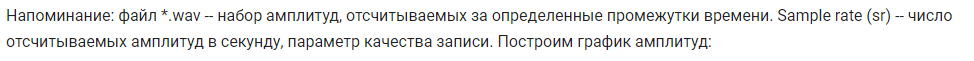

In [30]:
paths = []
categories = []
for i in glob.glob("data/fold1/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [0]
        paths += [i]
for i in glob.glob("data/fold2/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [1]
        paths += [i]
for i in glob.glob("data/fold3/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [2]
        paths += [i]
for i in glob.glob("data/fold4/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [3]
        paths += [i]

In [31]:
df = pd.DataFrame({"paths":paths, "categories":categories}).sample(frac=1).reset_index(drop=True)
df

,paths,categories
0,data/fold4\1405.mp3,3
1,data/fold3\494.mp3,2
2,data/fold3\670.mp3,2
3,data/fold1\3057.mp3,0
4,data/fold1\3458.mp3,0
...,...,...
1706,data/fold3\796.mp3,2
1707,data/fold4\1314.mp3,3
1708,data/fold4\1672.mp3,3
1709,data/fold3\1063.mp3,2


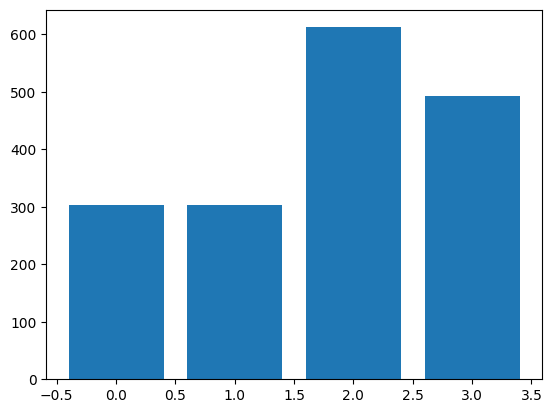

Counter({0: 303, 1: 303, 2: 612, 3: 493})

In [32]:
ct = Counter(categories)
plt.bar([x for x in ct.keys()], ct.values())
plt.show()
Counter(categories)

In [33]:
class CustomdDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 30
        self.new_freq = 16000
        self.top_db = 80
        self.n_fft = 1024
        self.n_mels = 64
            
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'paths']
        class_id = self.df.loc[idx, 'categories']

        arr, org_sr = torchaudio.load(audio_file)
        arr = torchaudio.functional.resample(arr, orig_freq=org_sr, new_freq=self.new_freq)
        org_sr =  self.new_freq


        num_rows, sig_len = arr.shape
        max_len = self.new_freq*self.duration
        if (sig_len > max_len):
            arr = arr[:,:max_len]
        elif (sig_len < max_len):
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            arr = torch.cat((pad_begin, arr, pad_end), 1)

        spec = transforms.MelSpectrogram(org_sr, n_fft=self.n_fft, hop_length=None, n_mels=self.n_mels)(arr)
        spec = transforms.AmplitudeToDB(top_db=self.top_db)(spec)
        return spec, class_id

In [34]:
from torch.utils.data import random_split

myds = CustomdDS(df)

num_train = round(len(myds) * 0.8)
num_val = len(myds) - round(len(myds) * 0.8)
train_ds, val_ds = random_split(myds, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [2]:
class AudioClassifier (nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []

        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=4)

        self.conv = nn.Sequential(*conv_layers)
 

    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
customModel = AudioClassifier().to(device)

In [11]:
torch.cuda.is_available()

False

In [4]:
!nvidia-smi

Thu Mar  9 00:43:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0  On |                  N/A |
|  0%   46C    P8    20W / 200W |    298MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(customModel.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

for epoch in range(num_epochs):
    
    customModel.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    for i, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        optimizer.zero_grad()
        outputs = customModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        _, prediction = torch.max(outputs,1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]


    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, train_loss: {avg_loss:.2f}, accuracy_train: {acc:.2f}')
    customModel.eval()
    
    correct_prediction = 0
    total_prediction = 0

    with torch.no_grad():
        loss_valid = 0
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = customModel(inputs)
            loss = criterion(outputs, labels)
            loss_valid += loss.item()
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction/total_prediction
    print(f'val_loss: {loss_valid/len(val_dl)}, accuracy_valid: {acc:.2f}')
    
   
print('Finished Training')

  0%|          | 0/86 [00:00<?, ?it/s]


RuntimeError: No audio I/O backend is available.

In [ ]:
str(torchaudio.get_audio_backend())

In [ ]:
!conda install -c conda-forge pysoundfile

In [45]:
!pip uninstall PySoundFile && pip install PySoundFile

     ---------------------------------------- 0.0/671.8 kB ? eta -:--:--
     ----------- -------------------------- 204.8/671.8 kB 4.1 MB/s eta 0:00:01
     -------------------------- ----------- 460.8/671.8 kB 4.8 MB/s eta 0:00:01
     -------------------------------------- 671.8/671.8 kB 4.7 MB/s eta 0:00:00
